In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Number of days for this dataset
n_days = 365*120

In [3]:
import pandas as pd
import numpy as np
# from sklearn.utils import shuffle

# Define the column names
cols = ['Breakfast', 'Morning_Tea', 'Lunch', 'Afternoon_Tea', 'Dinner']

In [4]:
# Create a dataframe with all False rows
df_false = pd.DataFrame(np.full((21900, len(cols)), False), columns=cols)

In [5]:
# Create a dataframe with randomly assigned True/False rows
df_random = pd.DataFrame(np.random.choice([True, False], size=(21900, len(cols))), columns=cols)

In [6]:
# Concatenate the dataframes
df_daily = pd.concat([df_false, df_random])

In [7]:
count_all_false = (df_daily == False).all(axis=1).sum()
count_all_false

22627

In [8]:
# Shuffle the dataframe
df_daily = df_daily.sample(frac=1).reset_index()

## 1.2 Create Label 'Toilet'

After creating the dataframe `df_daily`, we can add a new column called `Toilet`. For each row $t$ in df_daily, we can set the value in the `Toilet` column of row $t+1$ based on the values in the `Breakfast`, `Morning_Tea`, `Lunch`, `Afternoon_Tea`, and `Dinner` columns.

In [9]:
# Create a condition where all specified columns are False
condition = (df_daily[['Breakfast', 'Morning_Tea', 'Lunch', 'Afternoon_Tea', 'Dinner']] == False).all(axis=1)

# Shift the condition one row downwards (so that row t's condition affects row t+1)
condition = condition.shift(1)

# Use the condition to update 'Toilet' values. If condition is True, set 'Toilet' to False. If condition is False or NaN, set 'Toilet' to True.
df_daily['Toilet'] = np.where(condition, False, True)


In this code, we use the **any()** function along with the **axis=1** argument to check if any value in the specified columns is $True$. We then use the **shift()** function with $-1$ as the shift parameter to shift the values by one row. Finally, we use the **fill_value=False** argument to replace any $NaN$ values resulting from the shift operation with $False$.

In [10]:
df_daily = df_daily.drop('index', axis=1)

In [11]:
df_daily.shape

(43800, 6)

In [12]:
df_daily = df_daily.astype(int)

In [13]:
df_daily.shape

(43800, 6)

In [14]:
df_daily = df_daily.astype(int)

In [15]:
df_daily.head(10)

,Breakfast,Morning_Tea,Lunch,Afternoon_Tea,Dinner,Toilet
0,0,1,0,1,1,0
1,0,0,0,0,0,1
2,1,0,1,0,0,0
3,0,0,0,1,0,1
4,1,1,1,0,0,1
5,0,0,0,0,0,1
6,0,0,0,0,0,0
7,1,0,0,0,0,0
8,0,0,0,0,0,1
9,0,1,1,1,0,0


In [16]:
df_daily.describe()

,Breakfast,Morning_Tea,Lunch,Afternoon_Tea,Dinner,Toilet
count,43800.000000,43800.000000,43800.00000,43800.000000,43800.000000,43800.000000
mean,0.250365,0.249635,0.24895,0.245251,0.250890,0.483379
std,0.433228,0.432807,0.43241,0.430241,0.433531,0.499729
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [17]:
df_daily['Toilet'].value_counts()

0    22628
1    21172
Name: Toilet, dtype: int64

<AxesSubplot:xlabel='Toilet', ylabel='count'>

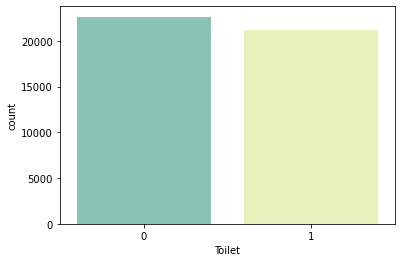

In [18]:
sns.countplot(x = df_daily['Toilet'], palette=["#7fcdbb", "#edf8b1"])

In [19]:
# # Replace 0 with 'F' and 1 with 'T'
# df_daily.replace({0: 'F', 1: 'T'}, inplace=True)

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from tensorflow.keras.models import Model

In [21]:
# Split dataset into train and validation
train = df_daily[:36500]
val = df_daily[36500:36500+36500]

In [22]:
# Create a time-series dataset from the dataframes, make it reusable
def timeseries_dataset(df, past, future):
    # I think shuffle should be False, correct me if I am wrong
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=np.array(df, dtype=np.float32),
        targets=None,
        sequence_length=past+future,
        sequence_stride = 1,
        shuffle = False,
        batch_size = 32,
    )

    ds = ds.map(lambda batch: (batch[:, :past, :], batch[:, past:, -1]))

    return ds

In [23]:
# Create training and validation datasets
past = 3  # previous 3 days
future = 2  # next 2 days

In [24]:
# Create a dictionary with column names as keys and empty lists as values
data = {
    'Breakfast': [],
    'Morning_Tea': [],
    'Lunch': [],
    'Afternoon_Tea': [],
    'Dinner': [],
    'Toilet': []
}

# Define the number of rows for the dataframe
num_rows = 10  # You can change this value to the desired number of rows

# Populate the dictionary with index numbers for each column
for i in range(num_rows):
    for col in data:
        data[col].append(i)

# Create the dataframe using the populated dictionary
df_temp = pd.DataFrame(data)

# Print the dataframe
print(df_temp)


   Breakfast  Morning_Tea  Lunch  Afternoon_Tea  Dinner  Toilet
0          0            0      0              0       0       0
1          1            1      1              1       1       1
2          2            2      2              2       2       2
3          3            3      3              3       3       3
4          4            4      4              4       4       4
5          5            5      5              5       5       5
6          6            6      6              6       6       6
7          7            7      7              7       7       7
8          8            8      8              8       8       8
9          9            9      9              9       9       9


In [25]:
train_temp = timeseries_dataset(df_temp, past, future)

In [26]:
def print_dataset(ds):
    for inputs, targets in ds:
        print("---Batch---")
        print("Feature:", inputs.numpy())
        print("Label:", targets.numpy())
        print("")

In [27]:
print_dataset(train_temp)

---Batch---
Feature: [[[1. 1. 1. 1. 1. 1.]
  [2. 2. 2. 2. 2. 2.]
  [3. 3. 3. 3. 3. 3.]]

 [[2. 2. 2. 2. 2. 2.]
  [3. 3. 3. 3. 3. 3.]
  [4. 4. 4. 4. 4. 4.]]

 [[3. 3. 3. 3. 3. 3.]
  [4. 4. 4. 4. 4. 4.]
  [5. 5. 5. 5. 5. 5.]]

 [[4. 4. 4. 4. 4. 4.]
  [5. 5. 5. 5. 5. 5.]
  [6. 6. 6. 6. 6. 6.]]

 [[5. 5. 5. 5. 5. 5.]
  [6. 6. 6. 6. 6. 6.]
  [7. 7. 7. 7. 7. 7.]]

 [[0. 0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 1. 1.]
  [2. 2. 2. 2. 2. 2.]]]
Label: [[4. 5.]
 [5. 6.]
 [6. 7.]
 [7. 8.]
 [8. 9.]
 [3. 4.]]



In [28]:
train_ds = timeseries_dataset(train, past, future)
val_ds = timeseries_dataset(val, past, future)

In [29]:
# Create subnetworks for gluten and lactose
input_layer = Input(shape=(past, df_daily.shape[-1]))

gluten_layer = LSTM(32)(input_layer[:, :, :3])
lactose_layer = LSTM(32)(input_layer[:, :, 3:5])


In [30]:
# Concatenate the outputs of the two subnetworks
concat_layer = Concatenate()([gluten_layer, lactose_layer])

# Dense layer for prediction
output_layer = Dense(1, activation='sigmoid')(concat_layer)

In [31]:
# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1141/1141 [==============================] - 8s 5ms/step - loss: 0.5970 - accuracy: 0.7126 - val_loss: 0.5813 - val_accuracy: 0.7332
Epoch 2/10
1141/1141 [==============================] - 5s 4ms/step - loss: 0.5793 - accuracy: 0.7335 - val_loss: 0.5756 - val_accuracy: 0.7392
Epoch 3/10
1141/1141 [==============================] - 5s 4ms/step - loss: 0.5762 - accuracy: 0.7324 - val_loss: 0.5732 - val_accuracy: 0.7333
Epoch 4/10
1141/1141 [==============================] - 5s 4ms/step - loss: 0.5750 - accuracy: 0.7313 - val_loss: 0.5725 - val_accuracy: 0.7327
Epoch 5/10
 828/1141 [====================>.........] - ETA: 1s - loss: 0.5747 - accuracy: 0.7311

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Prepare the test dataset
test = df_daily[-3650:]
test_ds = timeseries_dataset(test, past, future)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")